# 2048 Reinforcement learning

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from model.game import Game2048, UP, DOWN, LEFT, RIGHT
from player import play_many

## Hard-coded strategie

In [3]:
class RandomStrategy:
    def get_action(self, game):
        return np.random.randint(4)

In [4]:
class DumbStrategy:
    def Q(self, game, direction):
        grid = game.grid
        if game.can_move(direction):
            if direction == UP:
                return grid[0:2].sum()
            if direction == DOWN:
                return grid[2:4].sum()
            if direction == LEFT:
                return grid[:,0:2].sum()
            if direction == RIGHT:
                return grid[:,2:4].sum()
            
        return -1
    
    def get_action(self, game):
        return np.argmax([
            self.Q(game, UP),
            self.Q(game, RIGHT),
            self.Q(game, DOWN),
            self.Q(game, LEFT),
        ])

In [5]:
class CountMergedTileStrategy:
    def Q(self, game, direction):
        game0 = game.copy()
        moved, score = game0.play(direction)

        if moved == 0:
            return -1

        return 16 - np.count_nonzero(game0._grid)
    
    def get_action(self, game):
        return np.argmax([
            self.Q(game, UP),
            self.Q(game, RIGHT),
            self.Q(game, DOWN),
            self.Q(game, LEFT),
        ])

In [6]:
class OneStepScoreStrategy:
    def Q(self, game, direction):
        game0 = game.copy()
        moved, score = game0.play(direction)

        if moved == 0:
            return -1

        return score
    
    def get_action(self, game):
        return np.argmax([
            self.Q(game, UP),
            self.Q(game, RIGHT),
            self.Q(game, DOWN),
            self.Q(game, LEFT),
        ])

In [19]:
class NStepScoreStrategy:
    N = 2
    GAMMA = 1
    
    def V(self, game, iter_idx):
        if iter_idx == 0:
            return 0
        
        return np.max([
            self.Q(game, UP, iter_idx),
            self.Q(game, RIGHT, iter_idx),
            self.Q(game, DOWN, iter_idx),
            self.Q(game, LEFT, iter_idx),
        ])
    
    def Q(self, game, direction, iter_idx=None):
        if iter_idx is None:
            iter_idx = self.N

        game0 = game.copy()
        moved, score = game0.play(direction)

        if moved == 0:
            return -1

        v = self.V(game, iter_idx - 1)
        
        return score + self.GAMMA * v
    
    def get_action(self, game):
        return np.argmax([
            self.Q(game, UP),
            self.Q(game, RIGHT),
            self.Q(game, DOWN),
            self.Q(game, LEFT),
        ])

In [23]:
%%time

#strategy = RandomStrategy()
# strategy = DumbStrategy()
# strategy = CountMergedTileStrategy()
# strategy = OneStepScoreStrategy()
strategy = NStepScoreStrategy()

df = play_many(100, strategy)

CPU times: user 1min 5s, sys: 63.3 ms, total: 1min 5s
Wall time: 1min 5s


In [24]:
df.describe()

,score,max_tile,moves
count,100.000000,100.000000,100.000000
mean,3267.920000,249.600000,271.270000
std,1533.286532,139.299256,90.548592
min,832.000000,64.000000,110.000000
25%,1963.000000,128.000000,193.000000
50%,3250.000000,256.000000,274.500000
75%,3814.000000,256.000000,318.000000
max,7280.000000,512.000000,499.000000


In [31]:
df.moves.sum()

25758

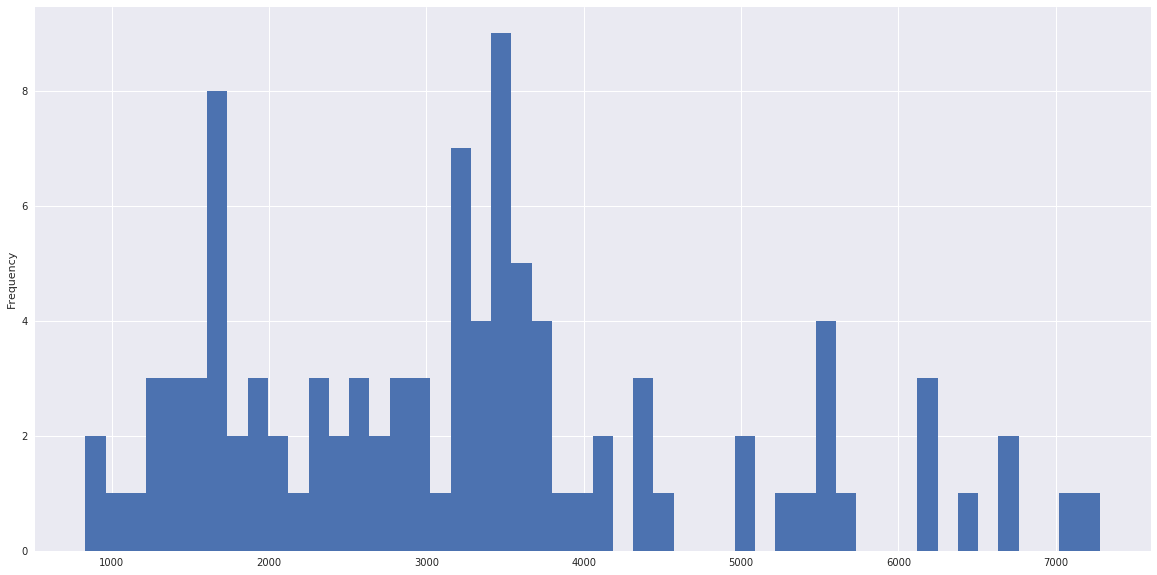

In [25]:
df.score.plot(kind='hist', bins=50)

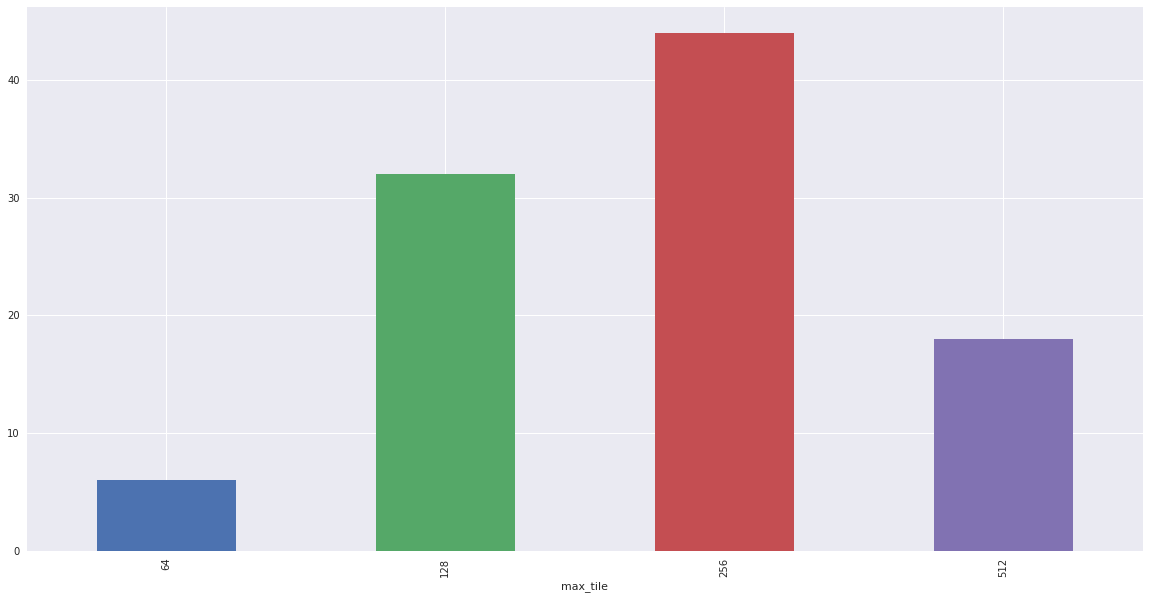

In [26]:
df.groupby(df.max_tile).score.count().plot.bar()

In [27]:
df.groupby(df.max_tile).score.count()

max_tile
64      6
128    32
256    44
512    18
Name: score, dtype: int64